In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import os
import email as em

from datetime import date, timedelta, datetime
from time import mktime
from email.utils import parsedate, parsedate_tz, mktime_tz
from email.parser import HeaderParser

from classes.gmail import GmailAccount

In [17]:
password = open(os.path.expanduser('~/.ssh/pw'), 'r').read().strip()

In [5]:
tyler = GmailAccount(username='tyleha@gmail.com', password=password)
tyler.login()

('OK', [b'tyleha@gmail.com authenticated (Success)'])

In [6]:
daysback = 70
notsince = 0
since = (date.today() - timedelta(daysback)).strftime("%d-%b-%Y")
before = (date.today() - timedelta(notsince)).strftime("%d-%b-%Y")

SEARCH = '(SENTSINCE {si} SENTBEFORE {bf})'.format(si=since, bf=before)
BODY = '(BODY.PEEK[TEXT])'
ALL_HEADERS = '(BODY.PEEK[HEADER.FIELDS (DATE TO CC FROM SUBJECT)])'
DATE = '(BODY.PEEK[HEADER.FIELDS (DATE)])'

In [12]:
#LOAD GMAIL EMAILS
received = tyler.load_parse_query(SEARCH, ALL_HEADERS, '"[Gmail]/All Mail"')
# sent = tyler.load_parse_query(SEARCH, ALL_HEADERS, '"[Gmail]/Sent Mail"')

In [18]:
def load_pickle(filepath, ftype='r'):
    """opens and closes pickled file and returns contained pickleobj"""
    f = open(filepath, ftype)
    contents = pickle.load(f)
    f.close()
    return contents    

def save_pickle(content, filepath, ftype='w'):
    """
    :return: pickle's weird dump output. not useful
    :content: the object to be saved (can be any type)
    :filepath: the string path, relative or not, at which to save
    :ftype: 'w' to write, 'wb' to write binary
    """
    f = open(filepath, ftype)
    xx = pickle.dump(content, f)
    f.close()
    return xx

# Do the pandas thing

In [19]:
import pandas as pd
import numpy as np
import pickle

In [20]:
def scrub_email(headers):   
    # IMAP sometimes returns fields with varying capitalization. Lowercase each header name.
    return dict([(title.lower(), value) for title, value in headers])

def try_parse_date(d):
    try:
        ts = pd.Timestamp(d)

        # IMAP is very much not perfect...some of my emails have no timezone
        # in their date string. ¯\_(ツ)_/¯
        if ts.tz is None: 
            ts = ts.tz_localize('UTC')

        # I moved from east coast to west coast in fall 2010, so automatically assume EST/PST 
        # before/after that date.
        if ts < pd.Timestamp('2010-09-04', tz='US/Eastern'):
            ts = ts.tz_convert('US/Eastern')
        else:
            ts = ts.tz_convert('US/Pacific')
        # I would have liked to avoid this whole parse_date method altogether and instead just
        # use pd.Timestamp(df.date), however Pandas is _really_ not built to handle DatetimeIndex
        # or PeriodIndex of anything other than a single timezone (see http://stackoverflow.com/a/17027507/1766755)
        # Because we care about timezone-naive datestamps and Pandas forces us to be timezone aware, 
        # we have to fall back to the datetime library and strip timezone from all our dates
        # using tzinfo=None.
        return pd.Timestamp(ts.to_datetime().replace(tzinfo=None))
    
    except:
        # Sometimes, IMAP just has dates formatted in a totally improper 
        # way...see 'Thursday , 10 Dec 2009 16:28:55, PST'. These are so few and far between and so
        # irregular that we'll just remove them from our dataset.
        return np.nan

In [21]:
email_dataset = load_pickle('/home/tyleha/git/all_emails', 'rb')

In [22]:
# Frequency
freq = 'M'
df = pd.DataFrame([scrub_email(email._headers) for email in email_dataset])
 
# This might take a minute...
df['timestamp'] = df.date.map(try_parse_date)
df = df.dropna(subset=['timestamp'])


In [23]:
# Now we're off to the races
df['hour'] = df.timestamp.map(lambda x: x.hour)
df = df.set_index('timestamp', drop=False)
df.index = df.index.to_period(freq)


In [24]:
# Scale our heatmap to the min/max range of our email data.
mindate = df.timestamp.min()
maxdate = df.timestamp.max()
pr = pd.period_range(mindate, maxdate, freq=freq)

# Initialize a new HeatMap dataframe where the indicies are actually Periods of time!
# Size the frame anticipating the correct number of rows (periods) and columns (hours in a day)
hm = pd.DataFrame(np.zeros([len(pr), 24]) , index=pr)

from classes.progress import ProgressBar

prog = ProgressBar(len(pr))
for i, period in enumerate(pr):
    # HERE'S where the magic happens...with pandas, when you structure your data correctly, it can be so terse that
    # you almost aren't sure the program does what it says it does...
    # For this period (month), find all emails within this month and count how many emails were received
    # within each hour of the day in that month. Wow. Takes more words to explain than to code.
    # Normally that would take you 3 or 4 for loops, constantly trying to catch edge cases and fencepost
    # problems. But here, it's as simple as you please.
    if period in df.index:
        hm.ix[period] = df.loc[[period]].hour.value_counts()
    prog.animate(i)
    
# If for some weird reason there was ever an hour period where you had no email,
# fill those NaNs with zeros.
hm.fillna(0, inplace=True)

 117 of 117    [##################### 100% #####################]    Time: 0:00:02    ETA: ...

# Heatmap Plot

In [295]:
# Hide that time I sent a bajillion wedding save the date emails
hm.ix[pd.Period('2013-04', 'M')][18] = 20

In [25]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import time
import matplotlib.gridspec as gridspec
%matplotlib inline

/home/tyleha/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


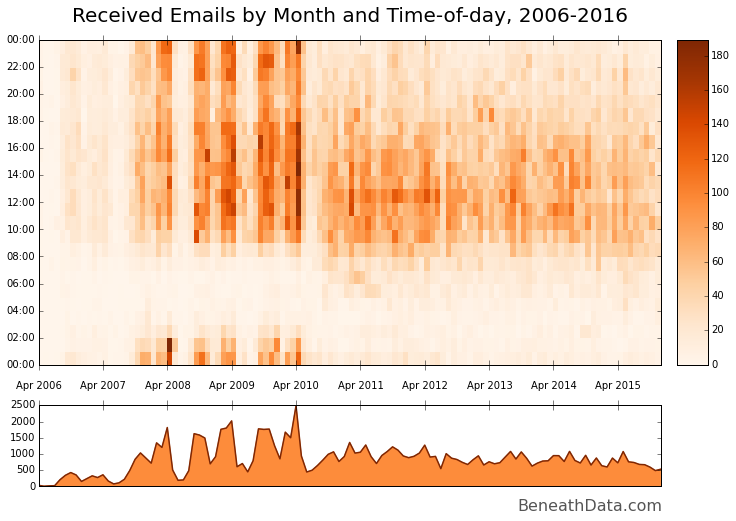

In [26]:
# Set up figure
fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2, 2, height_ratios=[4,1], width_ratios=[20,1])
gs.update(wspace=0.05)


### Plot our heatmap
ax = plt.subplot(gs[0])
x = dates.date2num([p.start_time for p in pr])
t = [datetime(2000, 1, 1, h, 0, 0) for h in range(24)]
t.append(datetime(2000, 1, 2, 0, 0, 0))
y = dates.date2num(t)
cm = plt.get_cmap('Oranges')
plt.pcolor(x, y, hm.transpose().as_matrix(), cmap=cm)

ax.xaxis.set_major_formatter(dates.DateFormatter('%b %Y'))
ax.yaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
ax.set_yticks(t[::2])
ax.set_xticks(x[::12])
ax.tick_params(axis='x', pad=14, length=10, direction='inout')
ax.set_xlim([x[0], x[-1]])
ax.set_ylim([t[0], t[-1]])

# Add a colorbar!
plt.colorbar(cax=plt.subplot(gs[1]))

#### Plot total emails over time 
ax2 = plt.subplot(gs[2])
total_email = df.groupby(level=0).hour.count()
plt.plot_date(total_email.index, total_email, '-', linewidth=1.5, color=cm(0.999))
ax2.fill_between(total_email.index, 0, total_email, color=cm(0.5))

ax2.xaxis.tick_top()
out = ax2.set_xticks(total_email.index[::12])
out = ax2.xaxis.set_ticklabels([])
ax2.tick_params(axis='x', pad=14, length=10, direction='inout')

ax.set_title("Received Emails by Month and Time-of-day, 2006-2016", fontdict={'size':20}, y=1.04)
ax.text(1.0, -0.45, "BeneathData.com", color='#555555', fontsize=16, ha='right', transform=ax.transAxes)


In [27]:
fig.savefig('received_emails_heatmap.png')

/home/tyleha/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


# Scratch City

In [193]:
def clean_name(fromstr):
    return fromstr.split('<')[0].strip().replace('"', '').replace('\n', '')

df['from_name'] = df['from'].map(clean_name)
df['from_name'].value_counts()[:7]

Tyler Hartley         11828
Tyler and Jen            66
tyleha@gmail.com         65
tlh2k@virginia.edu        8
Tyler                     3
Ty and Jen                2
TYLER.L HARTLEY           1
Name: from_name, dtype: int64

In [329]:
[clean_name(x) for x in .split('>,')]

['Leslie Alpert', 'Li Probies', 'Brent Via', 'Leah S. Goldman']

In [339]:
xx = df[df.cc != ''].ix[180]
xx
[clean_name(item) for item in xx.cc.split('>,')] + [clean_name(xx.to)]

['Leslie Alpert',
 'Li Probies',
 'Brent Via',
 'Leah S. Goldman',
 'Kyle Mihalcoe']

In [368]:
df['ccsplit'] = df.cc.str.split('>,')

In [371]:
s = df.ccsplit.apply(lambda x: pd.Series(x)).unstack()


''

In [379]:
s.ix[8179]

'Yousaf Sajid <yms4y@virginia.edu'

In [357]:
df.fillna('', inplace=True)

def get_all_recipients(item):
    ccs = [clean_name(item) for item in item.cc.split('>,')]
    to = [clean_name(item.to)]
    return to if ccs == [''] else to + ccs

all_names = []
for x in df.iterrows():
    all_names.append(get_all_recipients(x[1]))
    

In [365]:
pd.DataFrame(df.cc.str.split('>,').tolist(), index=df.index).unstack()

# s = df.cc.apply(lambda x: pandas.Series(x)).unstack();


    timestamp
0   2006-04          
    2006-04          
    2006-04          
    2006-04          
    2006-04          
    2006-04          
    2006-04          
    2006-04          
    2006-04          
    2006-04          
    2006-04          
    2006-04          
    2006-04          
    2006-06          
    2006-06          
    2006-06          
    2006-07          
    2006-08          
    2006-08          
    2006-08          
    2006-08          
    2006-08          
    2006-08          
    2006-08          
    2006-08          
    2006-08          
    2006-08          
    2006-08          
    2006-08          
    2006-08          
                 ... 
46  2015-12      None
    2015-12      None
    2015-12      None
    2015-12      None
    2015-12      None
    2015-12      None
    2015-12      None
    2015-12      None
    2015-12      None
    2015-12      None
    2015-12      None
    2015-12      None
    2015-12      None
    2015-12      N

In [364]:
df2 = df.join(pd.DataFrame(s.reset_index(level=0, drop=True))); df2

timestamp    
2006-04    0                                                  
           0                                                  
           0                                                  
           0                                                  
           0                                                  
           0                                                  
           0                                                  
           0                                                  
           0                                                  
           0                                                  
           0                                                  
           0                                                  
           0                                                  
2006-06    0                                                  
           0                                                  
           0                             

In [358]:
all_names[:10]

[['sdg3m@virginia.edu'],
 ['hag8g@virginia.edu'],
 ['dme2j@virginia.edu'],
 ['Michael Hartley'],
 ['tylerhartley@westminster.net'],
 ['Dana M. Elzey'],
 ['tyleha@gmail.com'],
 ['tyleha@gmail.com'],
 ['bi_line@yahoo.com'],
 ['tyleha@gmail.com']]

In [216]:
def clean_name(fromstr):
    return fromstr.split('<')[0].strip().replace('"', '').replace('\n', '')

rec['from_name'] = rec['from'].map(clean_name)
rec['from_name'].value_counts()[:11]

Tyler Hartley         11866
Jennifer Lundstrem     2165
Aaron Chevalier        1872
Michael Hartley        1708
jeremiah wander        1697
Judy Hartley           1188
Bryan Nichols           913
Jon Miller              806
Patrick McGettigan      793
Iris Jiang              723
Emily Whalen            663
Name: from_name, dtype: int64

In [268]:
cm = plt.get_cmap('Oranges')


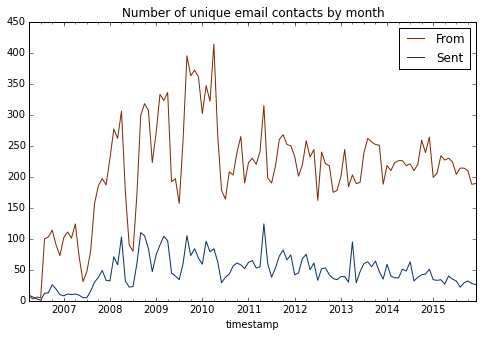

In [282]:
fig = plt.figure(figsize=(8,5))
g = rec.groupby(level=0)
ax = g['from'].nunique().plot(color=plt.get_cmap('Oranges')(0.999), label='From')
g = df.groupby(level=0)
ax = g['to'].nunique().plot(color=plt.get_cmap('Blues')(0.999), label='Sent')
plt.title('Number of unique email contacts by month')
plt.legend()
fig.savefig('asdf.png')

In [ ]:
xx.plot()

timestamp
2006-04      7
2006-05      3
2006-06      6
2006-07      5
2006-08    100
2006-09    103
2006-10    114
2006-11     90
2006-12     73
2007-01    102
2007-02    111
2007-03    101
2007-04    124
2007-05     71
2007-06     31
2007-07     47
2007-08     81
2007-09    157
2007-10    186
2007-11    197
2007-12    187
2008-01    230
2008-02    277
2008-03    262
2008-04    306
2008-05    176
2008-06     90
2008-07     80
2008-08    171
2008-09    299
          ... 
2013-07    239
2013-08    262
2013-09    256
2013-10    252
2013-11    251
2013-12    188
2014-01    218
2014-02    210
2014-03    223
2014-04    226
2014-05    226
2014-06    218
2014-07    221
2014-08    210
2014-09    220
2014-10    259
2014-11    239
2014-12    264
2015-01    199
2015-02    206
2015-03    234
2015-04    227
2015-05    230
2015-06    224
2015-07    204
2015-08    214
2015-09    214
2015-10    210
2015-11    188
2015-12    189
Freq: M, Name: from, dtype: int64

In [255]:

rec = df